In [1]:
# Setup chunk to install and load required packages
knitr::opts_chunk$set(warning = FALSE, message = FALSE)
suppressWarnings(if(!require("pacman")) install.packages("pacman"))

pacman::p_load('tidyverse', 'tidymodels', 'glmnet',
               'randomForest', 'xgboost','patchwork',
               'paletteer', 'here', 'doParallel', 'summarytools', 'statip')


Loading required package: pacman



In [2]:
# Initialize library
library(tidyverse)
library(patchwork)
library(statip)
library(glue)
library(summarytools)
library(tidymodels)
library(lubridate)
library(paletteer)
library(ggplot2)
#library(dplyr)
#library(statsr)
#library(GGally)
library(ggpubr)


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union




In [3]:
# Import the data into the R session
Saar_hour <- read.table("C:/Users/Daud/Desktop/01mainrepo/02prml/eeeic23/Saarbruecken-Saar-min.dat", header = TRUE, sep = "\t")
#Irr_data <- read_csv(file = "C:/Users/Daud/Google Drive/Phd Saarland/Paper by Dd/Phd_Themes/Res.2-Genration modeling (S-01.12.17)/Analysis of weather parameters/Saarbruecken-hour.csv", sep = ";")

# View first few rows
Saar_hour %>% 
  slice_head(n = 10)

m,dm,dy,h,mi,G_Gh,hs,G_Gex,G_Gh_hr,G_Dh,G_Gk,G_Dk,G_Bn,Ta,FF,G_Gcs,Td,PVprod
<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<int>
1,1,1,0,1,0,-63.0,0,0,0,0,0,0,8.9,2.1,0,8.2,0
1,1,1,0,2,0,-63.0,0,0,0,0,0,0,8.9,2.1,0,8.2,0
1,1,1,0,3,0,-63.1,0,0,0,0,0,0,8.9,2.1,0,8.2,0
1,1,1,0,4,0,-63.1,0,0,0,0,0,0,8.9,2.1,0,8.2,0
1,1,1,0,5,0,-63.2,0,0,0,0,0,0,8.9,2.1,0,8.2,0
1,1,1,0,6,0,-63.2,0,0,0,0,0,0,8.9,2.1,0,8.2,0
1,1,1,0,7,0,-63.2,0,0,0,0,0,0,8.9,2.1,0,8.2,0
1,1,1,0,8,0,-63.3,0,0,0,0,0,0,8.9,2.1,0,8.2,0
1,1,1,0,9,0,-63.3,0,0,0,0,0,0,8.9,2.1,0,8.2,0


In [4]:
library(dplyr)
Saar_hour <- Saar_hour %>% rename(PV = PVprod)
# Take a quick glance at the data
glimpse(Saar_hour)

Rows: 525,600
Columns: 18
$ m       <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ dm      <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ dy      <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ h       <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ mi      <int> 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,…
$ G_Gh    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ hs      <dbl> -63.0, -63.0, -63.1, -63.1, -63.2, -63.2, -63.2, -63.3, -63.3,…
$ G_Gex   <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ G_Gh_hr <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ G_Dh    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ G_Gk    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ G_Dk    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ G_Bn    <int

In [5]:
# Create a data frame of categorical features & label
categorical_features <- Saar_hour %>% 
  select(c(m, dm, dy, h, mi, PV))

# Pivot data to a long format
categorical_features <- categorical_features %>% 
  pivot_longer(!PV, names_to = "features", values_to = "values") %>%
  group_by(features) %>% 
  mutate(values = factor(values))


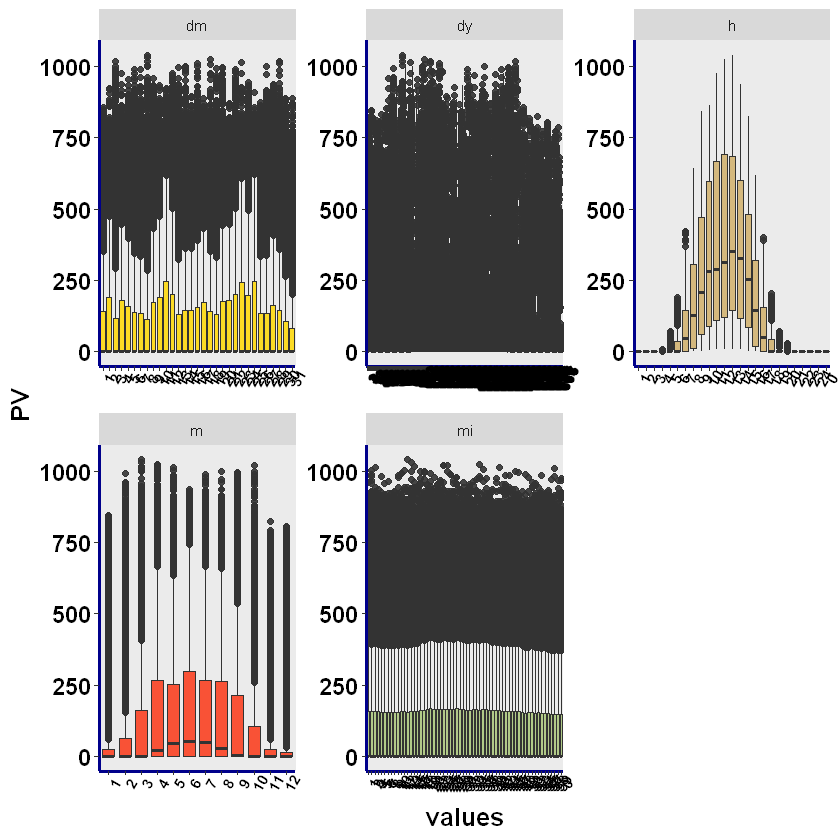

In [6]:
# Plot a box plot for each feature
categorical_features %>%
  ggplot() +
  geom_boxplot(aes(x = values, y = PV, fill = features), alpha = 0.9, show.legend = F) +
  facet_wrap(~ features, scales = 'free') +
  paletteer::scale_fill_paletteer_d("tvthemes::simpsons")+
  theme(
    panel.grid = element_blank(),
    axis.text.x = element_text(angle = 90))+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="red", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=9, angle = 60),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

setwd("C:/Users/Daud/Google Drive/Phd Saarland/Paper by Dd/Phd_Themes/Res.2-Genration modeling (S-01.12.17)/Analysis of weather parameters/T1_RE_P2_Analysis_of_Solar_radiations-Saarbrucken_jan2018_files/New/")
#ggsave("./Pre.png",Final_m_plt)
ggsave(filename = "PV_cat_dis.png", width=15, height=5)
#plt.plot

In [7]:
# Select desired features and labels
Saar_select <- Saar_hour %>% 
  select(c(m, h, dm, G_Gh, hs, G_Gex, G_Gh_hr, G_Dh, G_Gk, G_Dk, G_Bn, Ta, FF, G_Gcs, Td, PV)) %>% 
  # Encode certain features as categorical
  mutate(across(1:3, factor))

# Get a glimpse of your data
glimpse(Saar_select)

Rows: 525,600
Columns: 16
$ m       <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ h       <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ dm      <fct> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ G_Gh    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ hs      <dbl> -63.0, -63.0, -63.1, -63.1, -63.2, -63.2, -63.2, -63.3, -63.3,…
$ G_Gex   <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ G_Gh_hr <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ G_Dh    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ G_Gk    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ G_Dk    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ G_Bn    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ Ta      <dbl> 8.9, 8.9, 8.9, 8.9, 8.9, 8.9, 8.9, 8.9, 8.9, 8.9, 8.9, 8.9, 8.…
$ FF      <dbl

In [8]:
# Split 70% of the data for training and the rest for testing
set.seed(2056)
Saar_split <- Saar_select %>% 
  initial_split(prop = 0.7,
  # splitting data evenly on the holiday variable
                strata = m)

# Extract the data in each split
Saar_train <- training(Saar_split)
Saar_test <- testing(Saar_split)


cat("Training Set", nrow(Saar_train), "rows",
    "\nTest Set", nrow(Saar_test), "rows")


Warning message:
"Too little data to stratify.
• Resampling will be unstratified."


Training Set 367920 rows 
Test Set 157680 rows

In [9]:
# Build a linear model specification
lm_spec <- 
  # Type
  linear_reg() %>% 
  # Engine
  set_engine("lm") %>% 
  # Mode
  set_mode("regression")

In [10]:
# Train a linear regression model
lm_mod <- lm_spec %>% 
  fit(PV ~ ., data = Saar_train)

# Print the model object
lm_mod


parsnip model object


Call:
stats::lm(formula = PV ~ ., data = data)

Coefficients:
(Intercept)           m2           m3           m4           m5           m6  
   1.945825     1.339478     3.847047     5.637863     7.123833     6.329266  
         m7           m8           m9          m10          m11          m12  
   6.185037     4.262320     3.628171     3.033347     0.968137    -0.690493  
         h1           h2           h3           h4           h5           h6  
  -0.431168    -0.746511    -0.927340    -1.063214    -2.369299    -2.512117  
         h7           h8           h9          h10          h11          h12  
  -0.578663     1.866140     3.105332     2.532120     1.026778    -0.658631  
        h13          h14          h15          h16          h17          h18  
  -0.796025    -0.307608     0.285071     0.818872     0.898657     1.234196  
        h19          h20          h21          h22          h23          h24  
   1.427645     2.317946     1.689029     1.05

In [11]:
# Make predictions on test set
pred <- lm_mod %>% 
  predict(new_data = Saar_test)

# View predictions
pred %>% 
  slice_head(n = 5)

.pred
<dbl>
-2.885592
-2.883384
-2.882832
-2.882832
-2.881727


In [12]:
# Predict rentals for the test set and bind it to the test_set
results <- Saar_test %>% 
  bind_cols(lm_mod %>% 
    # Predict rentals
    predict(new_data = Saar_test) %>% 
      rename(predictions = .pred))

# Compare predictions
results %>% 
  select(c(PV, predictions)) %>% 
  slice_head(n = 10)


PV,predictions
<int>,<dbl>
0,-2.885592
0,-2.883384
0,-2.882832
0,-2.882832
0,-2.881727
0,-2.881727
0,-2.881175
0,-2.881175
0,-2.970470


`geom_smooth()` using formula 'y ~ x'



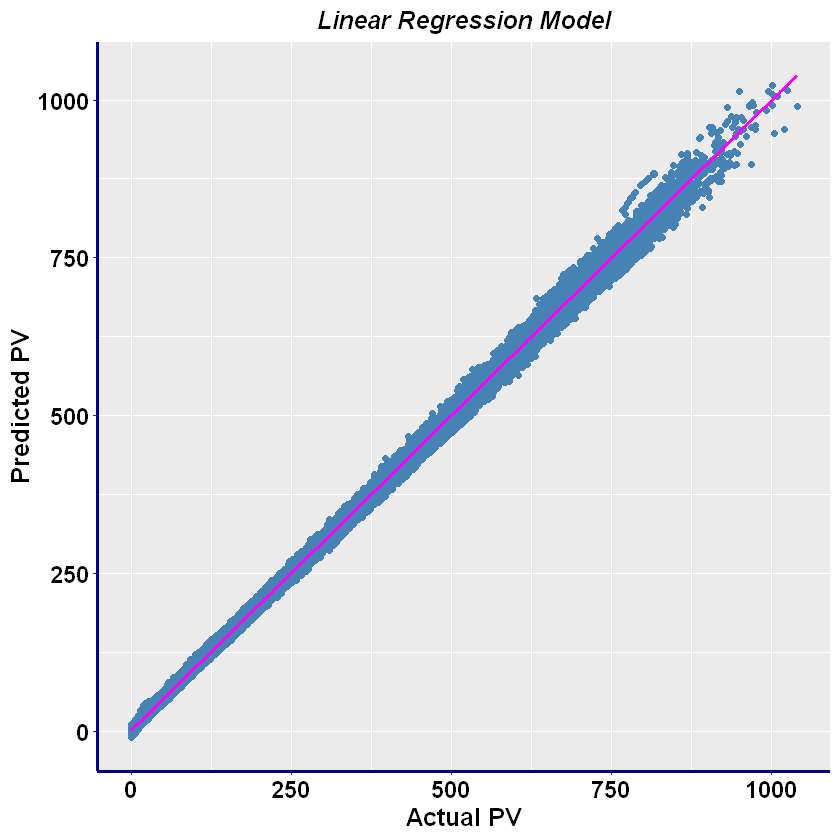

In [13]:
# Visualise the results
results %>% 
  ggplot(mapping = aes(x = PV, y = predictions)) +
  geom_point(size = 1.6, color = "steelblue") +
  # Overlay a regression line
  geom_smooth(method = "lm", se = F, color = 'magenta') +
  ggtitle("Linear Regression Model") +
  xlab("Actual PV") +
  ylab("Predicted PV") +
  theme(plot.title = element_text(hjust = 0.5))+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 0),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


In [14]:
# Multiple regression metrics
eval_metrics <- metric_set(rmse, rsq)

# Evaluate RMSE, R2 based on the results
eval_metrics(data = results,
             truth = PV,
             estimate = predictions)


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,6.0704386
rsq,standard,0.9991644


`geom_smooth()` using formula 'y ~ x'



[[1]]
# A tibble: 2 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard      11.1  
2 rsq     standard       0.997

[[2]]


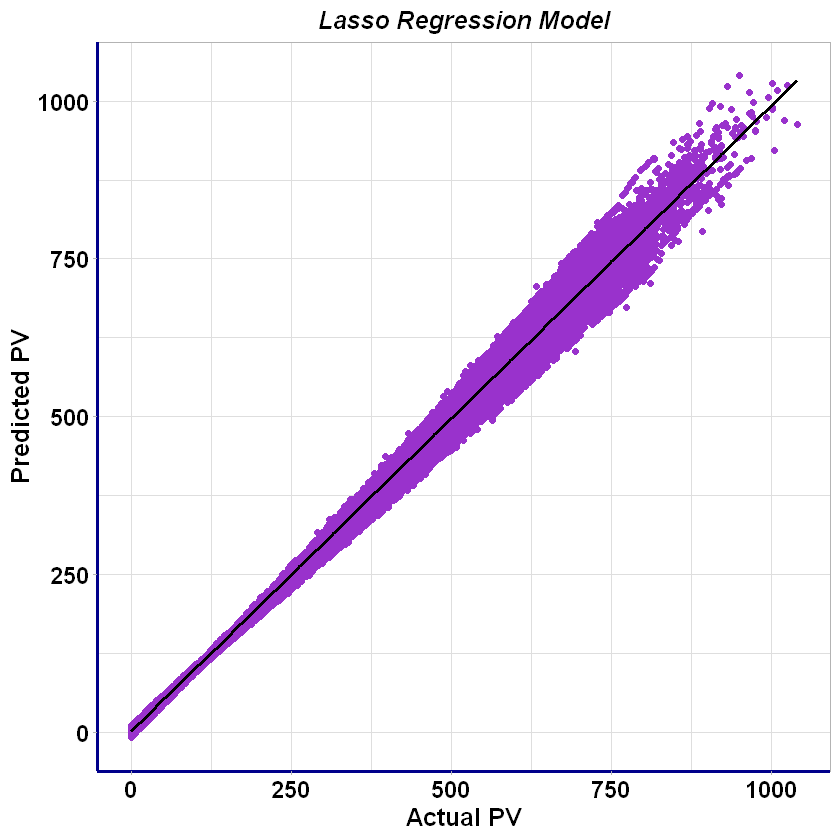

In [15]:
# Build a lasso model specification
lasso_spec <- linear_reg(
  engine = "glmnet",
  mode = "regression",
  penalty = 1,
  mixture = 1)

# Train a lasso regression model
lasso_mod <- lasso_spec %>% 
  fit(PV ~ ., data = Saar_train)

# Make predictions for test data
results_lasso <- Saar_test %>% 
  bind_cols(lasso_mod %>% predict(new_data = Saar_test) %>% 
              rename(predictions = .pred))

# Evaluate the model
lasso_metrics <- eval_metrics(data = results_lasso,
                                    truth = PV,
                                    estimate = predictions) 


# Plot predicted vs actual
theme_set(theme_light())
lasso_plt <- results_lasso %>% 
  ggplot(mapping = aes(x = PV, y = predictions)) +
  geom_point(size = 1.6, color = 'darkorchid') +
  # overlay regression line
  geom_smooth(method = 'lm', color = 'black', se = F) +
  ggtitle("Lasso Regression Model") +
  xlab("Actual PV") +
  ylab("Predicted PV") +
  theme(plot.title = element_text(hjust = 0.5))+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 0),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Return evaluations
list(lasso_metrics, lasso_plt)
  

parsnip model object

n= 367920 

node), split, n, deviance, yval
      * denotes terminal node

1) root 367920 16216740000 123.261000  
  2) G_Gk< 345.5 304693  1446098000  36.958060  
    4) G_Gk< 107.5 254000   101614600   9.069248 *
    5) G_Gk>=107.5 50693   157052400 176.696500 *
  3) G_Gk>=345.5 63227  1564856000 539.157600  
    6) G_Gk< 662.5 31845   183030800 404.821400 *
    7) G_Gk>=662.5 31382   223983400 675.475700 *

`geom_smooth()` using formula 'y ~ x'



[[1]]
# A tibble: 2 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard      42.6  
2 rsq     standard       0.959

[[2]]


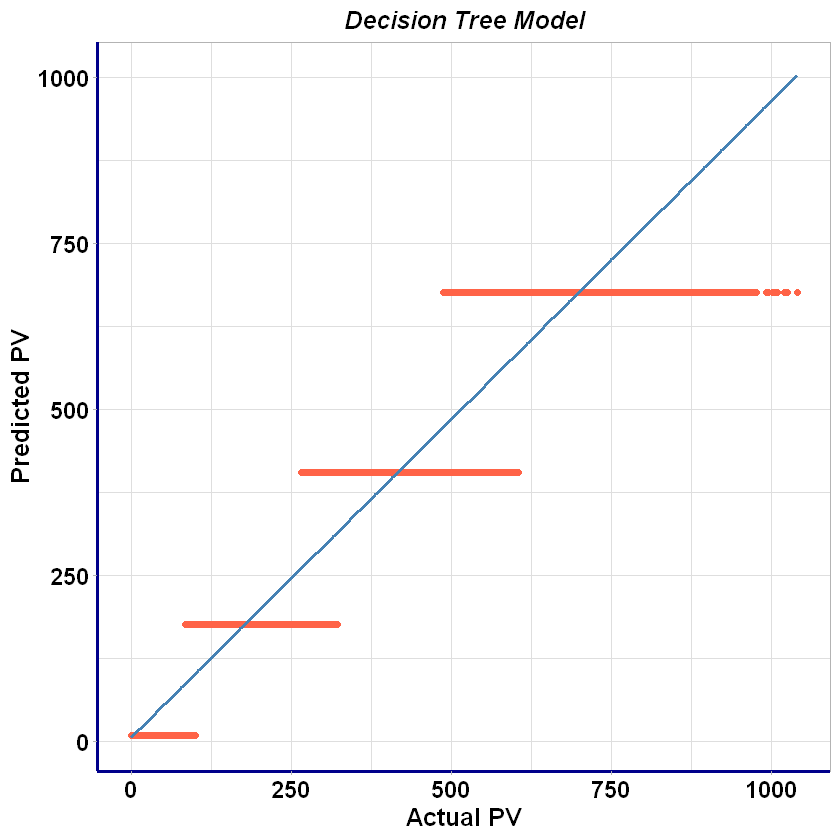

In [16]:
# Build a decision tree specification
tree_spec <- decision_tree(
  engine = "rpart",
  mode = "regression")

# Train a decision tree model 
tree_mod <- tree_spec %>% 
  fit(PV ~ ., data = Saar_train)

# Print model
tree_mod

# Make and bind predictions to test data a
results_DT <- tree_mod %>% 
  augment(new_data = Saar_test) %>% 
  rename(predictions = .pred)

# Evaluate the model
tree_metrics <- eval_metrics(data = results_DT,
                                  truth = PV,
                                  estimate = predictions)

# Plot predicted vs actual
tree_plt <- results_DT %>% 
  ggplot(mapping = aes(x = PV, y = predictions)) +
  geom_point(color = 'tomato') +
  # overlay regression line
  geom_smooth(method = 'lm', color = 'steelblue', se = F) +
  ggtitle("Decision Tree Model") +
  xlab("Actual PV") +
  ylab("Predicted PV") +
  theme(plot.title = element_text(hjust = 0.5))+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 0),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))
# Return evaluations
list(tree_metrics, tree_plt)

In [21]:
# For reproducibility
#set.seed(2056)

# Build a random forest model specification
rf_spec <- rand_forest() %>% 
  set_engine('randomForest') %>% 
  set_mode('regression')

# Train a random forest model 
rf_mod <- rf_spec %>% 
  fit(PV ~ ., data = Saar_train)

# Print model
rf_mod

ERROR: Error: cannot allocate vector of size 1.4 Gb


In [18]:





# Make and bind predictions to test data a
results_RF <- rf_mod %>% 
  augment(new_data = Saar_test) %>% 
  rename(predictions = .pred)


# Evaluate the model
rf_metrics <- eval_metrics(data = results_RF,
                                  truth = PV,
                                  estimate = predictions)



ERROR: Error: cannot allocate vector of size 1.4 Gb


In [17]:

# Plot predicted vs actual
rf_plt <- results_RF %>% 
  ggplot(mapping = aes(x = PV, y = predictions)) +
  geom_point(color = '#6CBE50FF') +
  # overlay regression line
  geom_smooth(method = 'lm', color = '#2B7FF9FF', se = F) +
  ggtitle("Random Forest Model") +
  xlab("Actual PV") +
  ylab("Predicted PV") +
  theme(plot.title = element_text(hjust = 0.5))+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 0),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Return evaluations
list(rf_metrics, rf_plt)


ERROR: Error: cannot allocate vector of size 1.4 Gb


In [22]:
# For reproducibility
set.seed(2056)

# Build an xgboost model specification
boost_spec <- boost_tree() %>% 
  set_engine('xgboost') %>% 
  set_mode('regression')

# Train an xgboost model 
boost_mod <- boost_spec %>% 
  fit(PV ~ ., data = Saar_train)


# Print model
boost_mod


# Make and bind predictions to test data a
results_BT <- boost_mod %>% 
  augment(new_data = Saar_test) %>% 
  rename(predictions = .pred)

# Evaluate the model
boost_metrics <- eval_metrics(data = results_BT,
                                  truth = PV,
                                  estimate = predictions) 

# Plot predicted vs actual
boost_plt <- results_BT %>% 
  ggplot(mapping = aes(x = PV, y = predictions)) +
  geom_point(color = '#4D3161FF') +
  # overlay regression line
  geom_smooth(method = 'lm', color = 'black', se = F) +
  ggtitle("Boosting Ensemble Model") +
  xlab("Actual PV") +
  ylab("Predicted PV") +
  theme(plot.title = element_text(hjust = 0.5))+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 0),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))
# Return evaluations
list(boost_metrics, boost_plt)

parsnip model object

##### xgb.Booster
raw: 76.6 Kb 
call:
  xgboost::xgb.train(params = list(eta = 0.3, max_depth = 6, gamma = 0, 
    colsample_bytree = 1, colsample_bynode = 1, min_child_weight = 1, 
    subsample = 1), data = x$data, nrounds = 15, watchlist = x$watchlist, 
    verbose = 0, nthread = 1, objective = "reg:squarederror")
params (as set within xgb.train):
  eta = "0.3", max_depth = "6", gamma = "0", colsample_bytree = "1", colsample_bynode = "1", min_child_weight = "1", subsample = "1", nthread = "1", objective = "reg:squarederror", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.evaluation.log()
# of features: 80 
niter: 15
nfeatures : 80 
evaluation_log:
    iter training_rmse
       1    170.386602
       2    119.404578
---                   
      14      2.875978
      15      2.572327

ERROR: Error in xgboost::xgb.DMatrix(data = new_data, missing = NA): std::bad_alloc


In [ ]:
# Specify a recipe
Saar_recipe <- recipe(PV ~ ., data = Saar_train) %>% 
  step_normalize(all_numeric_predictors()) %>% 
  step_dummy(all_nominal_predictors()) 

# Print out recipe
Saar_recipe


# Summary of the recipe
summary(Saar_recipe)

Recipe

Inputs:

      role #variables
   outcome          1
 predictor         17

Operations:

Centering and scaling for all_numeric_predictors()
Dummy variables from all_nominal_predictors()

variable,type,role,source
<chr>,<chr>,<chr>,<chr>
m,nominal,predictor,original
dm,nominal,predictor,original
h,nominal,predictor,original
G_Gk,numeric,predictor,original
Lg,numeric,predictor,original
G_Gh,numeric,predictor,original
G_Gref,numeric,predictor,original
hs,numeric,predictor,original
G_Gex,numeric,predictor,original


In [ ]:
# xgboost specification
boost_spec <- boost_tree() %>% 
  set_engine('xgboost') %>% 
  set_mode('regression')

# Create the workflow
boost_workflow <- workflow() %>% 
  add_recipe(Saar_recipe) %>% 
  add_model(boost_spec)

# Print out workflow
boost_workflow


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: boost_tree()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_normalize()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────
Boosted Tree Model Specification (regression)

Computational engine: xgboost 


In [ ]:
# Train the model
boost_workflow <- boost_workflow %>% 
  fit(data = Saar_train)

boost_workflow

boost_workflow %>% 
  predict(new_data = Saar_test %>% dplyr::slice(1:6))



══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: boost_tree()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_normalize()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────
##### xgb.Booster
raw: 54.5 Kb 
call:
  xgboost::xgb.train(params = list(eta = 0.3, max_depth = 6, gamma = 0, 
    colsample_bytree = 1, colsample_bynode = 1, min_child_weight = 1, 
    subsample = 1), data = x$data, nrounds = 15, watchlist = x$watchlist, 
    verbose = 0, nthread = 1, objective = "reg:squarederror")
params (as set within xgb.train):
  eta = "0.3", max_depth = "6", gamma = "0", colsample_bytree = "1", colsample_bynode = "1", min_child_weight = "1", subsample = "1", nthread = "1", objective = "reg:squarederror", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.evaluation.log()
# of features: 78 
niter: 15
nfeatures : 78 

.pred
<dbl>
0.002852751
0.002852751
0.002852751
25.591062546
35.289718628
0.002852751


In [ ]:
args(boost_tree)

function (mode = "unknown", engine = "xgboost", mtry = NULL, 
    trees = NULL, min_n = NULL, tree_depth = NULL, learn_rate = NULL, 
    loss_reduction = NULL, sample_size = NULL, stop_iter = NULL) 
NULL

In [ ]:
# Specify a recipe
Saar_recipe <- recipe(PV ~ ., data = Saar_train) %>% 
  step_normalize(all_numeric_predictors()) %>% 
  step_dummy(all_nominal_predictors()) 


# Make a tunable model specification
boost_spec <- boost_tree(trees = 50,
                         tree_depth = tune(),
                         learn_rate = tune()) %>% 
  set_engine('xgboost') %>% 
  set_mode('regression')


# Bundle a recipe and model spec using a workflow
boost_workflow <- workflow() %>% 
  add_recipe(Saar_recipe) %>% 
  add_model(boost_spec)

# Print workflow
boost_workflow



══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: boost_tree()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_normalize()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────
Boosted Tree Model Specification (regression)

Main Arguments:
  trees = 50
  tree_depth = tune()
  learn_rate = tune()

Computational engine: xgboost 


tree_depth,learn_rate
<int>,<dbl>
1,0.0100
4,0.0100
8,0.0100
11,0.0100
15,0.0100
1,0.0825
4,0.0825
8,0.0825
11,0.0825


tree_depth,learn_rate,.metric,.estimator,mean,n,std_err,.config
<int>,<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
8,0.1550,rmse,standard,1.530959,5,0.1841332,Preprocessor1_Model13
11,0.1550,rmse,standard,1.547182,5,0.1824617,Preprocessor1_Model14
15,0.1550,rmse,standard,1.556148,5,0.1862034,Preprocessor1_Model15
4,0.1550,rmse,standard,1.607901,5,0.1410604,Preprocessor1_Model12
8,0.2275,rmse,standard,1.657188,5,0.1511982,Preprocessor1_Model18


tree_depth,learn_rate,.config
<int>,<dbl>,<chr>
8,0.155,Preprocessor1_Model13


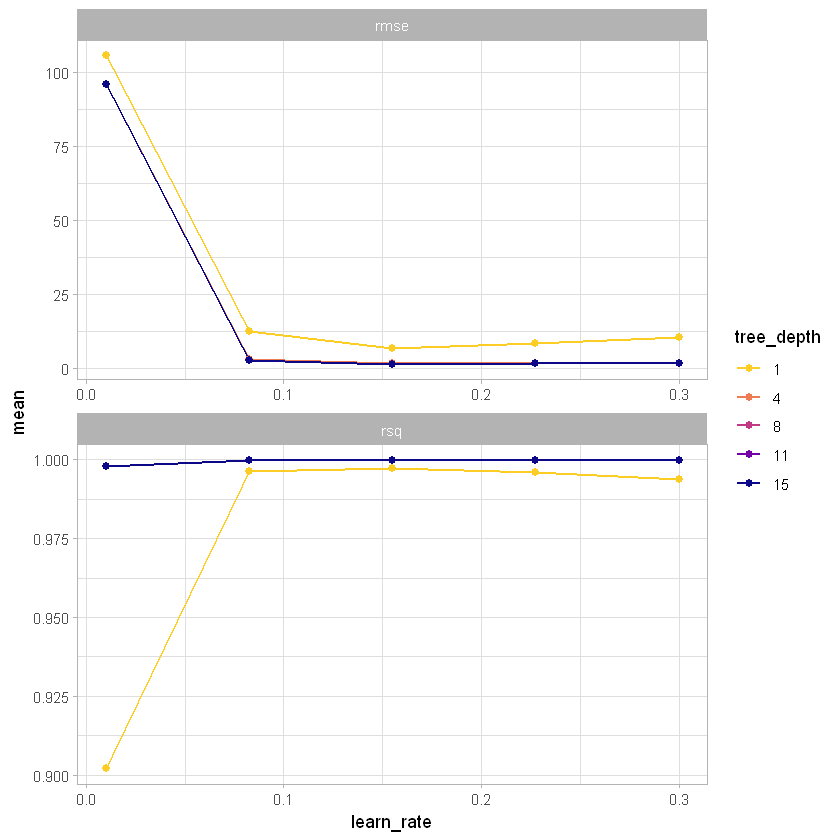

In [ ]:
# Create a grid of tuning parameters
tree_grid <- grid_regular(tree_depth(),
                  # You can specify hyperparameter ranges too
learn_rate(range = c(0.01, 0.3), trans = NULL), levels = 5)

# Display hyperparameter combinations that will be used for tuning
tree_grid

set.seed(2056)
# 5 fold CV repeated once
Saar_folds <- vfold_cv(data = Saar_train, v = 5, repeats = 1)


# Allow parallel processing
doParallel::registerDoParallel()

# Model tuning via grid search
set.seed(2020)
tree_grid <- tune_grid(
  object = boost_workflow,
  resamples = Saar_folds,
  grid = tree_grid
)


# Visualize the results
tree_grid %>% 
  collect_metrics() %>% 
  mutate(tree_depth = factor(tree_depth)) %>% 
  ggplot(mapping = aes(x = learn_rate, y = mean,
                       color = tree_depth)) +
  geom_line(size = 0.6) +
  geom_point(size = 2) +
  facet_wrap(~ .metric, scales = 'free', nrow = 2)+
  scale_color_viridis_d(option = "plasma", begin = .9, end = 0)


tree_grid %>% 
  show_best('rmse')

# Select the tree with the best RMSE
best_tree <- tree_grid %>% 
  select_best('rmse')

# Display best tree
best_tree


In [ ]:
# Update workflow
final_wf <- boost_workflow %>% 
  finalize_workflow(best_tree)

# Print final workflow
final_wf

# Make a last fit
final_fit <- final_wf %>% 
  last_fit(Saar_split)


# Collect metrics
final_fit %>% 
  collect_metrics()

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: boost_tree()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_normalize()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────
Boosted Tree Model Specification (regression)

Main Arguments:
  trees = 50
  tree_depth = 8
  learn_rate = 0.155

Computational engine: xgboost 


.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
rmse,standard,1.3363217,Preprocessor1_Model1
rsq,standard,0.9999014,Preprocessor1_Model1


In [ ]:
# Extract trained workflow
Saar_boost_model <- final_fit$.workflow[[1]]

# Save trained workflow
saveRDS(Saar_boost_model, 'Saar_boost_model.rds')

# Load the model
loaded_model <- readRDS("Saar_boost_model.rds")

# Extract predictors
bike_new <- Saar_test %>% 
  dplyr::slice(5:9)

# Use the model to predict rentals
results_FN <- loaded_model %>% 
  augment(Saar_test)

# See model predictions 
results_FN

m,dm,h,G_Gk,Lg,G_Gh,G_Gref,hs,G_Gex,G_Bh,Sd,Ld,G_Dk,G_Dh,G_Bn,Ts,Ta,PV,.pred
<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>
1,1,1,0,0,0,0,0.0,0,0,0,0,0,0,0,3.5,6.2,0,0.003549768
1,1,3,0,0,0,0,0.0,0,0,0,0,0,0,0,3.3,6.6,0,0.003549768
1,1,8,0,0,0,0,0.0,0,0,0,0,0,0,0,3.5,6.0,0,0.003549768
1,1,11,28,3446,28,6,12.6,308,0,0,3446,28,28,0,6.2,6.4,25,25.609237671
1,1,12,40,4917,41,8,16.3,396,0,1,4917,40,41,0,6.5,6.7,35,35.328384399
1,1,18,0,0,0,0,0.0,0,0,0,0,0,0,0,4.3,6.2,0,0.004283639
1,1,22,0,0,0,0,0.0,0,0,0,0,0,0,0,2.7,5.4,0,0.003549768
1,1,24,0,0,0,0,0.0,0,0,0,0,0,0,0,2.0,5.1,0,0.003549768
1,2,7,0,0,0,0,0.0,0,0,0,0,0,0,0,1.8,3.5,0,0.003549768


In [ ]:
# Replace negatives in column StudyHours with the mean study hours
results_FN <- results_FN %>%
  mutate(predictions = replace(.pred, .pred < 0, 0))
# Print the data frame
results_FN


m,dm,h,G_Gk,Lg,G_Gh,G_Gref,hs,G_Gex,G_Bh,Sd,Ld,G_Dk,G_Dh,G_Bn,Ts,Ta,PV,.pred,predictions
<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
1,1,1,0,0,0,0,0.0,0,0,0,0,0,0,0,3.5,6.2,0,0.003549768,0.003549768
1,1,3,0,0,0,0,0.0,0,0,0,0,0,0,0,3.3,6.6,0,0.003549768,0.003549768
1,1,8,0,0,0,0,0.0,0,0,0,0,0,0,0,3.5,6.0,0,0.003549768,0.003549768
1,1,11,28,3446,28,6,12.6,308,0,0,3446,28,28,0,6.2,6.4,25,25.609237671,25.609237671
1,1,12,40,4917,41,8,16.3,396,0,1,4917,40,41,0,6.5,6.7,35,35.328384399,35.328384399
1,1,18,0,0,0,0,0.0,0,0,0,0,0,0,0,4.3,6.2,0,0.004283639,0.004283639
1,1,22,0,0,0,0,0.0,0,0,0,0,0,0,0,2.7,5.4,0,0.003549768,0.003549768
1,1,24,0,0,0,0,0.0,0,0,0,0,0,0,0,2.0,5.1,0,0.003549768,0.003549768
1,2,7,0,0,0,0,0.0,0,0,0,0,0,0,0,1.8,3.5,0,0.003549768,0.003549768


[[1]]


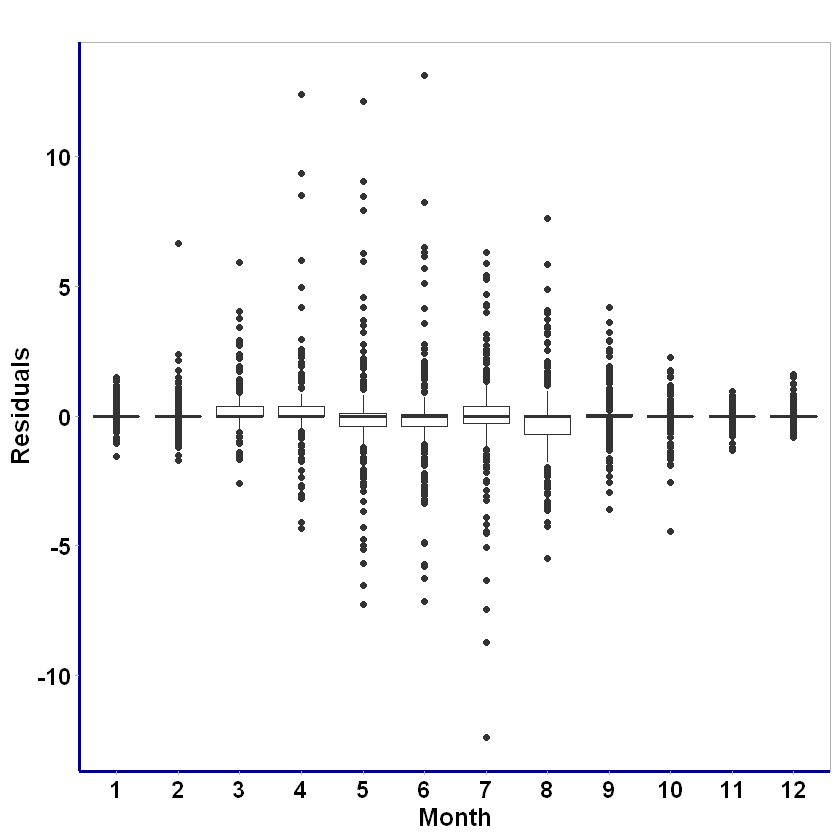

In [ ]:

theme_set(theme_light())
Final_mplt <- results_FN %>% 
  select(c(m, PV , predictions)) %>% 

ggplot(mapping = aes(x = m, y = PV-predictions)) +
  geom_boxplot()+
  #, alpha = 0.9, show.legend = F) +
  #facet_wrap(~ h, scales = 'free') +
  # overlay regression line
  ggtitle("") +
  xlab("Month") +
  ylab("Residuals") +
  paletteer::scale_fill_paletteer_d("tvthemes::simpsons")+
  theme(
    panel.grid = element_blank(),
    axis.text.x = element_text(angle = 60))+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 0),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

 #ggplot(mapping = aes(x = PV, y = predictions)) +
 # geom_point(color = '#4D3161FF') +
 # # overlay regression line
 # geom_smooth(method = 'lm', color = 'black', se = F) +
 # ggtitle("Daily Bike Share Predictions") +
 # xlab("Actual Labels") +
 # ylab("Predicted Labels") +
 # theme(plot.title = element_text(hjust = 0.5))
setwd("C:/Users/Daud/Google Drive/Phd Saarland/Paper by Dd/Phd_Themes/Res.2-Genration modeling (S-01.12.17)/Analysis of weather parameters/T1_RE_P2_Analysis_of_Solar_radiations-Saarbrucken_jan2018_files/New/")
#ggsave("./Pre.png",Final_m_plt)
ggsave(filename = "MonRes.png", width=10, height=5)
#plt.plot

list(Final_mplt)


[[1]]


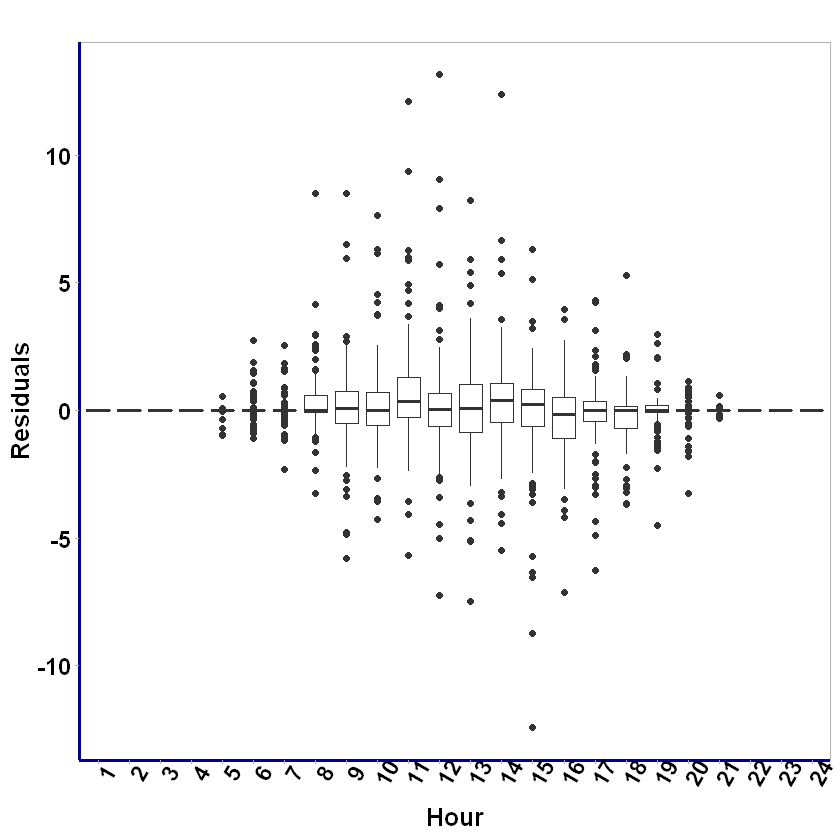

In [ ]:
theme_set(theme_light())
Final_hplt <- results_FN %>% 
  select(c(h, PV , predictions)) %>% 

ggplot(mapping = aes(x = h, y = PV-predictions)) +
  geom_boxplot()+
  #, alpha = 0.9, show.legend = F) +
  #facet_wrap(~ h, scales = 'free') +
  ggtitle("") +
  xlab("Hour") +
  ylab("Residuals") +
  paletteer::scale_fill_paletteer_d("tvthemes::simpsons")+
  theme(
    panel.grid = element_blank(),
    axis.text.x = element_text(angle = 60))+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 60),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))


list(Final_hplt)

setwd("C:/Users/Daud/Google Drive/Phd Saarland/Paper by Dd/Phd_Themes/Res.2-Genration modeling (S-01.12.17)/Analysis of weather parameters/T1_RE_P2_Analysis_of_Solar_radiations-Saarbrucken_jan2018_files/New/")
#ggsave("./Pre.png",Final_m_plt)
ggsave(filename = "HrRes.png", width=10, height=5)
#plt.plot



[[1]]


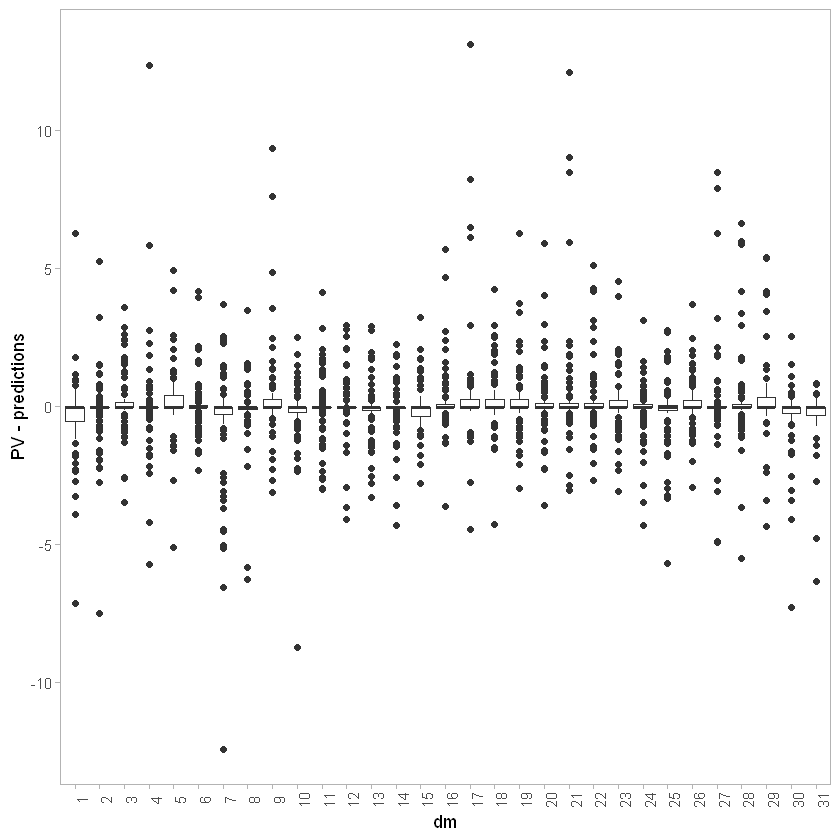

In [ ]:
theme_set(theme_light())
Final_dmplt <- results_FN %>% 
  select(c(dm, PV , predictions)) %>% 

ggplot(mapping = aes(x = dm, y = PV-predictions)) +
  geom_boxplot()+
  #, alpha = 0.9, show.legend = F) +
  #facet_wrap(~ h, scales = 'free') +
  paletteer::scale_fill_paletteer_d("tvthemes::simpsons")+
  theme(
    panel.grid = element_blank(),
    axis.text.x = element_text(angle = 90))

 #ggplot(mapping = aes(x = PV, y = predictions)) +
 # geom_point(color = '#4D3161FF') +
 # # overlay regression line
 # geom_smooth(method = 'lm', color = 'black', se = F) +
 # ggtitle("Daily Bike Share Predictions") +
 # xlab("Actual Labels") +
 # ylab("Predicted Labels") +
 # theme(plot.title = element_text(hjust = 0.5))


list(Final_dmplt)

`geom_smooth()` using formula 'y ~ x'



[[1]]
# A tibble: 2 × 3
  .metric .estimator .estimate
  <chr>   <chr>          <dbl>
1 rmse    standard        1.34
2 rsq     standard        1.00

[[2]]


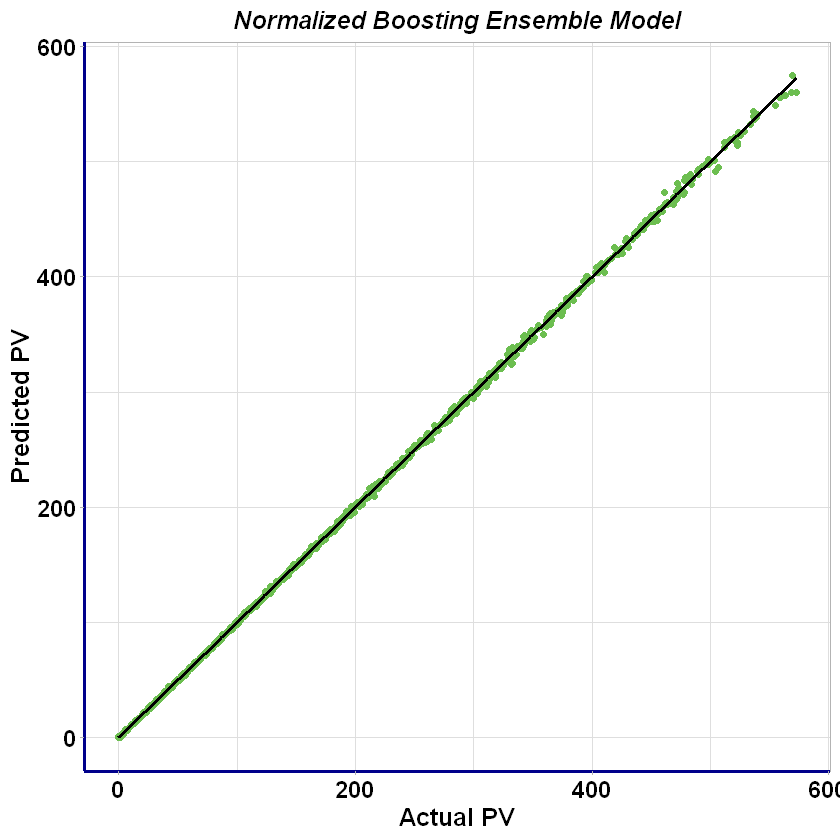

In [ ]:
# For reproducibility
set.seed(2056)

# Evaluate the model
boost_metrics <- eval_metrics(data = results_FN,
                                  truth = PV,
                                  estimate = predictions) 

# Plot predicted vs actual
boost_plt <- results_FN %>% 
  ggplot(mapping = aes(x = PV, y = predictions)) +
  geom_point(color = '#6CBE50FF') +
  geom_smooth(method = 'lm', color = 'black', se = F) +
  # overlay regression line
  ggtitle("Normalized Boosting Ensemble Model") +
  xlab("Actual PV") +
  ylab("Predicted PV") +
  theme(plot.title = element_text(hjust = 0.5))+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 0),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

# Return evaluations
list(boost_metrics, boost_plt)

In [ ]:
Final_plt_h <- results_FN %>% 
  select(c(h, PV , predictions)) %>% 
  group_by(h)%>%
  summarise(mean_pv = mean(PV),mean_pre = mean(predictions))
  

#ggplot(mapping = aes(x = h, y = PV)) +
#  geom_boxplot()+
  #, alpha = 0.9, show.legend = F) +
  #facet_wrap(~ h, scales = 'free') +
 # paletteer::scale_fill_paletteer_d("tvthemes::simpsons")+
 # theme(
 #   panel.grid = element_blank(),
 #   axis.text.x = element_text(angle = 90))

list(Final_plt_h)

h,mean_pv,mean_pre
<fct>,<dbl>,<dbl>
1,0.00000000,3.549768e-03
2,0.00000000,3.549768e-03
3,0.00000000,3.549768e-03
4,0.00000000,3.549768e-03
5,0.09401709,1.161111e-01
6,19.12000000,1.907306e+01
7,41.52678571,4.149812e+01
8,122.76842105,1.224694e+02
9,160.79207921,1.606757e+02


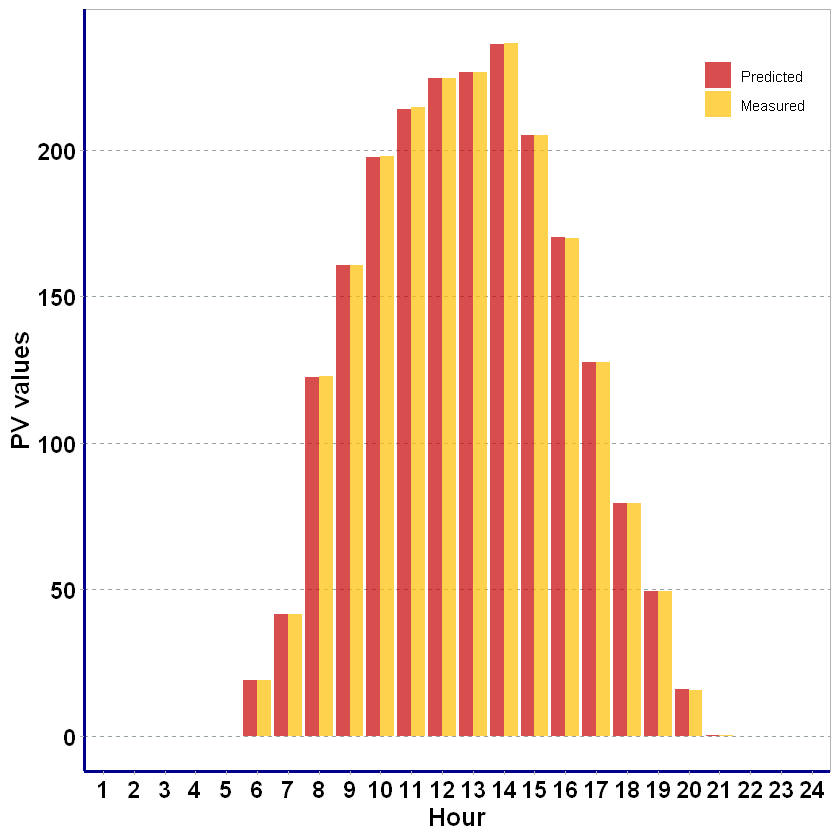

In [ ]:
df_final <- Final_plt_h %>% 
  select(h, mean_pv, mean_pre) %>%
  #mutate(m = fct_reorder(m, .desc = TRUE)) %>% 
  pivot_longer(!h, names_to = "Metrics", values_to = "Values")

# Compare numeric variables with bar plots
ggplot(data = df_final) +
  geom_bar(mapping = aes(x = h, y = Values, fill = factor(Metrics,labels=c("Predicted","Measured"))), alpha = 0.7, stat = "identity", position = position_dodge(width = 0.9)) +
  xlab('Hour') +
  ylab('PV values') +
  scale_fill_paletteer_d("calecopal::kelp1") +
  theme(
    panel.grid = element_blank(),
    panel.grid.major.y = element_line(color = '#95a5a6',
                                      linetype = 'dashed',
                                      size = 0.5),
    axis.text.x = element_text(angle = 90),
    legend.title = element_blank()
    
  )+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 0),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

setwd("C:/Users/Daud/Google Drive/Phd Saarland/Paper by Dd/Phd_Themes/Res.2-Genration modeling (S-01.12.17)/Analysis of weather parameters/T1_RE_P2_Analysis_of_Solar_radiations-Saarbrucken_jan2018_files/New/")
#ggsave("./Pre.png",Final_m_plt)
ggsave(filename = "hpred.png", width=10, height=5)
#plt.plot


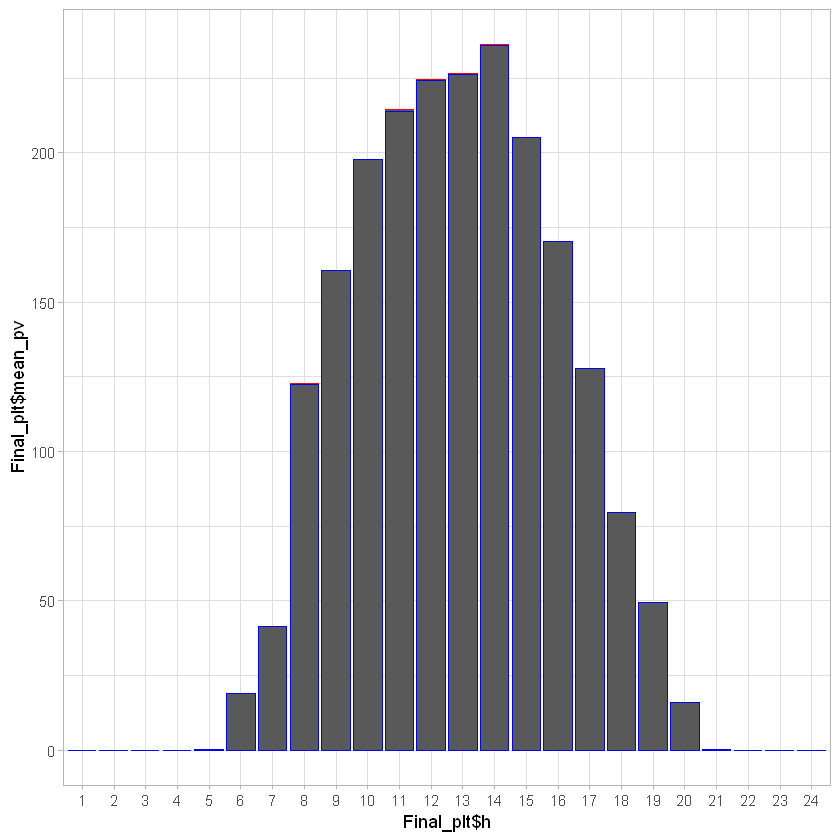

In [ ]:
#theme_set(theme_light())
#r_int <- as.integer(Final_plt$mean_pre)
#df<-data.frame(Final_plt$h,Final_plt$mean_pre, Final_plt$mean_pv)
#g<-ggplot(df, aes(Final_plt$h, Final_plt$mean_pv))+ geom_bar(stat = "identity", colour="red")
#g<-g+geom_bar(data=df, aes(Final_plt$h, Final_plt$mean_pre), stat = "identity", colour="blue")
#print(g)

In [ ]:
df1<-data.frame(x=Final_plt$h,y=Final_plt$mean_pre)
df2<-data.frame(x=Final_plt$h,y=Final_plt$mean_pv)
df1
ggplot(df1, aes(x,y))+geom_dotplot(aes(colour="red"),binaxis = "y", stackdir = "center", fill = "white", stroke = 2)+
  geom_dotplot(data = df2,aes(colour="blue"),binaxis = "y", stackdir = "center",dotsize = 0.5)+
  labs(color="Legend text")


#ggplot(data=Final_plt1,aes(x = h, y = mean_pre))+geom_line(aes(color="First line"))+
#  geom_line(data=Final_plt2,aes(color="Second line"))+
#  labs(color="Legend text")

ERROR: Error in data.frame(x = Final_plt$h, y = Final_plt$mean_pre): object 'Final_plt' not found


m,mean_pv,mean_pre
<fct>,<dbl>,<dbl>
1,17.73967,17.66386
2,32.65728,32.58451
3,75.00000,74.74186
4,120.96154,120.68942
5,154.96279,154.96227
6,159.03587,159.05916
7,155.66376,155.64479
8,143.76682,143.93790
9,85.58515,85.49330


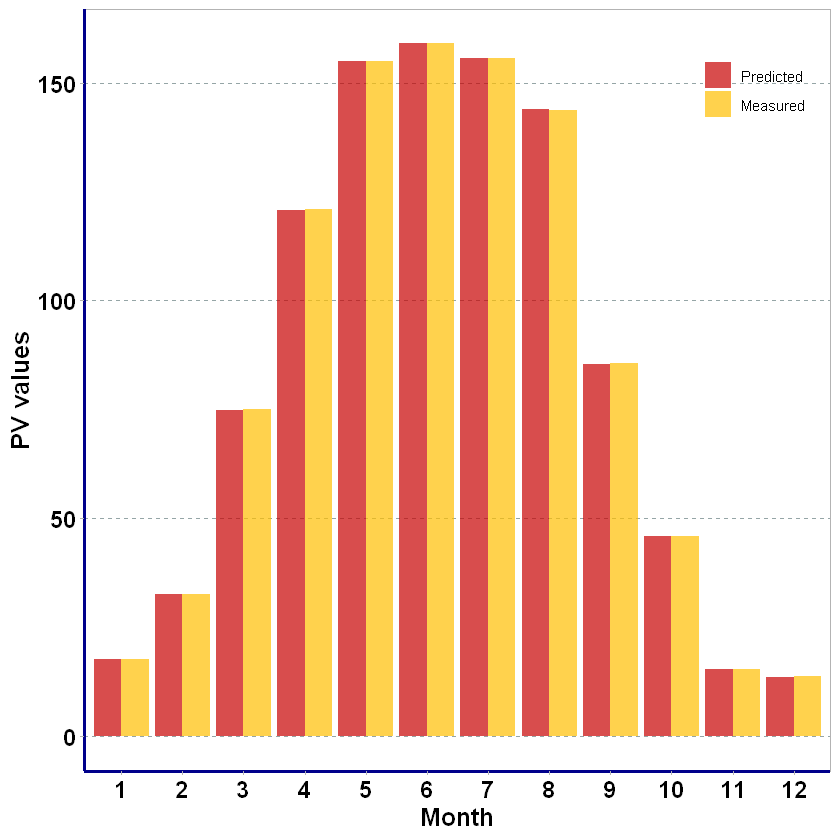

In [ ]:
Final_m_plt <- results_FN %>% 
  select(c(m, PV , predictions)) %>% 
  group_by(m)%>%
  summarise(mean_pv = mean(PV),mean_pre = mean(predictions))
  
Final_m_plt

dff_final <- Final_m_plt %>% 
  select(m, mean_pv, mean_pre) %>%
  #mutate(m = fct_reorder(m, .desc = TRUE)) %>% 
  pivot_longer(!m, names_to = "Metrics", values_to = "Values")

# Compare numeric variables with bar plots
ggplot(data = dff_final) +
  geom_bar(mapping = aes(x = m, y = Values, fill = factor(Metrics,labels=c("Predicted","Measured"))), alpha = 0.7, stat = "identity", position = position_dodge(width = 0.9)) +
  xlab('Month') +
  ylab('PV values') +
  scale_fill_paletteer_d("calecopal::kelp1") +
  theme(
    panel.grid = element_blank(),
    panel.grid.major.y = element_line(color = '#95a5a6',
                                      linetype = 'dashed',
                                      size = 0.5),
    axis.text.x = element_text(angle = 90),
    legend.title = element_blank()
    
  )+
  theme(legend.position = c(0.9, 0.9), legend.background = element_blank(),
      plot.title = element_text(color="black", size=15, face="bold.italic"),
      axis.title.x = element_text(color="black", size=15, face="bold"),
      axis.text.x = element_text(face="bold", color="black", size=14, angle = 0),
      axis.title.y = element_text(color="black", size=15, face="bold"),
      axis.text.y = element_text(face="bold", color="black", size=14),
      axis.line = element_line(colour = "darkblue", size = 1,
                               linetype = "solid"))

setwd("C:/Users/Daud/Google Drive/Phd Saarland/Paper by Dd/Phd_Themes/Res.2-Genration modeling (S-01.12.17)/Analysis of weather parameters/T1_RE_P2_Analysis_of_Solar_radiations-Saarbrucken_jan2018_files/New/")
#ggsave("./Pre.png",Final_m_plt)
ggsave(filename = "mpred.png", width=10, height=5)
#plt.plot